## Eval all losses

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%autoreload

In [3]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import segmentation_models_pytorch as smp
from natsort import natsorted
from uloss_wmh.fitting.fitter import StandardLitModelWrapper
from uloss_wmh.fitting.optimizer_constructor import OptimizerConfigurator, standard_configurations
from tqdm import tqdm

In [4]:
from uloss_wmh.evaluate.eval_metrics.weighted_average_challenge_metrics import weighted_challenge_metrics

In [5]:
from uloss_wmh.evaluate.eval_metrics.challenge_metrics import do_challenge_metrics, per_model_chal_stats, challenge_results_combined_lists

In [6]:
# loss functions
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss, DiceCELoss, DiceFocalLoss
from uloss_wmh.loss_functions.brier import Brier, BrierPlusDice
from uloss_wmh.loss_functions.odyssey_dice import SoftDiceLoss, DC_and_topk_loss
from uloss_wmh.loss_functions.odyssey_ND_Crossentropy import TopKLoss, CrossentropyND
from uloss_wmh.loss_functions.dice_plusplus import DicePlusPlusLoss

### loading the train, val and test datasets in 3D this time.

In [7]:
from ulw_data.torch_dataset.challenge_dataset_3D import load_3D_wmh_chal
from ulw_data.torch_dataset.challenge_data_pipeline import train_data_pipeline

In [8]:
collated_folder = "/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset_norm05/preprocessed/collated/"
train_ds, val_ds = train_data_pipeline(ds_path=collated_folder, val_proportion=0.15, seed=5, transforms=None, dims=3)

In [9]:
test_dss = load_3D_wmh_chal(ds_path=collated_folder, train=False, combine=False, remove_mask_channel=False)

In [10]:
len(test_dss)

5

In [11]:
test_dss[4][0]['uid']

'test_Utrecht_1'

In [12]:
# computing the voxel histogram for each image in the test dataset.
example = test_dss[0][0]['image'][0]

In [13]:
flat = example.view(-1)
flat = flat[flat != 0]

In [14]:
# get volumes:
from uloss_wmh.evaluate.eval_metrics.WMH_volume import GT_volumes

ys3d = []
for ds in test_dss:
    for data in ds:
        label = data['label']
        ys3d.append(label)
    # break # UNCOMMENT DEBUG
    
volumes = GT_volumes(ys3d, 0.0003)
# volumes = volumes[0:10] ## UNCOMMENT DEBUG

Text(0.5, 0, 'WMH Volume per individual - $mm^3$')

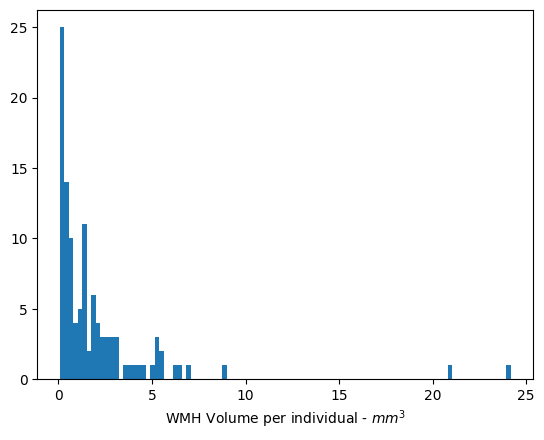

In [15]:
plt.hist(volumes, bins=100)
plt.xlabel(r"WMH Volume per individual - $mm^3$")

In [16]:
masks = []
for ds in test_dss:
    for data in ds:
        mask = data['image'][2]
        masks.append(mask)
    # break # UNCOMMENT DEBUG

In [17]:
test_dss[0][0]['label'].dtype

torch.int64

In [18]:
labels_dss = [[] for _ in range(len(test_dss))]
labels = []

for i, ds in enumerate(test_dss):
    for data in ds:
        label = data['label'].squeeze()
        labels.append(label)
        labels_dss[i].append(label==1)
    # break # UNCOMMMENT DEBUG

In [19]:
def plot_lesion_coverage_statistics1(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, folder_name):
    plt.plot(u_thresholds, mean_FN_coverage)
    plt.title(f"{folder_name}")
    plt.xlim((0, 1.1))
    plt.xlabel("Uncertainty threshold")
    plt.ylim((0, 1))
    plt.ylabel("mean FN coverage")
    plt.savefig(f"new_model_results/{folder_name}/" + "mean_FN_coverage" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()
    
def plot_lesion_coverage_statistics2(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, folder_name):

    plt.plot(u_thresholds, size_entirely_missed_lesions)
    plt.title(f"{folder_name}")
    plt.xlim((0, 1.1))
    plt.xlabel("Uncertainty threshold")
    plt.ylim((0, 7))
    plt.ylabel("size of entirely missed lesions")
    plt.savefig(f"new_model_results/{folder_name}/" + "size_entirely_missed_lesions" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()
    
def plot_lesion_coverage_statistics3(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, folder_name):
    plt.plot(u_thresholds, mean_missed_lesion_coverage)
    plt.title(f"{folder_name}")
    plt.xlim((0, 1.1))
    plt.xlabel("Uncertainty threshold")
    plt.ylim((0, 1))
    plt.ylabel("mean missed lesion coverage")
    plt.savefig(f"new_model_results/{folder_name}/" + "mean_missed_lesion_coverage" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

    
def plot_lesion_coverage_statistics4(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, folder_name):
    
    plt.plot(u_thresholds, prop_entirely_missed)
    plt.title(f"{folder_name}")
    plt.xlim((0, 1.1))
    plt.xlabel("Uncertainty threshold")
    plt.ylim((0, 0.4))
    plt.ylabel("proprtion of lesions entirely missed in uncertainty map")
    plt.savefig(f"new_model_results/{folder_name}/" + "prop_entirely_missed" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [20]:
def load_model_preds(model, t=1):
    preds_dss = []
    with torch.no_grad():
        model.eval()
        for ds in test_dss:
            preds_domain = []
            for data in tqdm(ds):
                inp = data['image'].cuda().moveaxis(-1, 0)
                inp = inp[:,0:2] # remove the mask channel
                out = model(inp)
                
                if out.shape[1] > 1:
                    out = torch.softmax(out/t, dim=1)
                else:
                    out = torch.sigmoid(out/t)
                
                preds_domain.append(out.moveaxis(0, -1).squeeze().cpu())
            preds_dss.append(preds_domain)
            # break # UNCOMMENT DEBUG
    
    # get combined list of all domains together
    preds = []
    for p in preds_dss:
        preds.extend(p)
        
    return preds, preds_dss

In [21]:
def combined_challenge_metrics(preds_domain, labels_domain, model, folder_name):
    results_domain = []
    for i in range(len(preds_domain)):
        results_domain.append(per_model_chal_stats([(p.argmax(dim=0)==1) for p in preds_domain[i]], labels_domain[i], do_argmax=False))
        
    results_combined_df = challenge_results_combined_lists(results_domain, folder_name)
    
    return results_combined_df, results_domain

In [22]:
def dice_distribution(combined_metrics, folder_name):
    ### dice only.
    chart = sns.boxplot(data=combined_metrics, y="loss_name", x="dice")
    chart.set_yticklabels(chart.get_yticklabels(), rotation=90)
    title_str = f"Dice distribution - {folder_name}"
    plt.title(title_str)
    plt.xlim((0,1))
    plt.xlabel("Dice")
    plt.savefig(f"new_model_results/{folder_name}/" + "dice_dist" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [23]:
def AVD_Dice_plot(data, folder_name):
    sns.jointplot(data, x='dice', y='avd')
    plt.xlabel('Dice - per Test Set Individual')
    plt.ylabel('AVD - per Test Set Individual')
    plt.suptitle(f"AVD vs Dice: {folder_name}")
    plt.xlim((0, 1))
    plt.ylim((0, 350))
    plt.savefig(f"new_model_results/{folder_name}/" + "avd_dice_plot" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [24]:
def AVD_Volume_plot(volumes, data, folder_name):
    plt.scatter(volumes, data['avd'])
    plt.xscale('log')
    plt.title(f"AVD vs Volume: {folder_name}")
    plt.xlabel("WMH GT volume")
    plt.ylim((0, 400))
    plt.ylabel("AVD")
    plt.savefig(f"new_model_results/{folder_name}/" + "avd_volume_plot" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [25]:
def get_inputs(test_datasets):
    inputs = []
    for dataset in test_datasets:
        for data in dataset:
            inputs.append(data['image'])
        # break # UNCOMMENT DEBUG
    return inputs

def get_labels(test_datasets):
    labels = []
    for dataset in test_datasets:
        for data in dataset:
            labels.append(data['label'].squeeze()==1)
        # break # UNCOMMENT DEBUG
    return labels


# since the area that I want to check is  predominantly confidently 0, I should compute values at n-step dilation.
from kornia.morphology import dilation

def dilate_considered_area(pred, label, threshold, steps=0):
    pred = pred
    step0_area = (pred > threshold) | (label == 1)
    step0_area = step0_area.moveaxis(-1,0).unsqueeze(1) # step0_area requries shape B C H W
    
    result = step0_area.type(torch.float32)
    for step in range(steps):
        result = dilation(result, kernel=torch.ones(3, 3).to(result.device), engine='convolution')
    
    return result.squeeze().moveaxis(0, -1).type(torch.long)

def get_n_step_dilated_voxels(pred, label, threshold, steps):
    dilated = dilate_considered_area(pred, label, threshold=threshold, steps=steps)
    return pred[dilated==1]

def get_prediction_voxels(labels, model_preds, threshold=0.01, steps=2):
    prediction_voxels = []
    for i in tqdm(range(len(labels))):
        label = labels[i].cuda()
        pred = model_preds[i].cuda()
        voxels = get_n_step_dilated_voxels(pred, label, threshold=threshold, steps=steps)
        prediction_voxels.append(voxels.reshape(-1).cpu())

    prediction_voxels = torch.cat(prediction_voxels)
    return prediction_voxels

In [26]:
def softmax_confidence_distribution(prediction_voxels, folder_name):
    sns.histplot(prediction_voxels, bins=20)
    plt.xlabel(f"Softmax Confidence - {folder_name}")
    plt.savefig(f"new_model_results/{folder_name}/" + "softmax_confidence_distribution" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [27]:


def compute_calibration_curve(predictions, labels, prediction_threshold=0., convert_to_numpy=True, num_bins=20):
    """Computes the calibration curve of a model.
    
    modified from a chat with google bard.

    Args:
    predictions: A list of pytorch tensors of shape (batch_size, height, width).
    labels: A list of pytorch tensors of shape (batch_size, height, width).
    prediction_threshold: the minimim prediction confidence to be considered

    Returns:
    A tuple of (calibration_curve, expected_calibration_error).
    The calibration_curve is a list of tuples of (confidence, accuracy).
    The expected_calibration_error is the average distance between the model's
    confidence and a perfectly calibrated model.
    
    """

    # Convert the predictions and labels to numpy arrays.
    if convert_to_numpy:
        predictions = torch.stack(predictions)
        labels = torch.stack(labels)
        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()

    # Bin the predictions into 10 equally spaced bins.
    bins = np.linspace(prediction_threshold, 1, num_bins)
    bin_indices = np.digitize(predictions, bins)
    #print(bins)
    
    # Compute the accuracy in each bin.
    accuracies = np.zeros(num_bins)
    confidences = np.zeros(num_bins)
    for i in tqdm(range(num_bins)):
        accuracies[i] = np.mean(labels[bin_indices == i])
        confidences[i] = np.mean(predictions[bin_indices == i])

    # Compute the expected calibration error.
    expected_calibration_error = np.mean(np.abs(confidences[1:] - accuracies[1:]))

    # Return the calibration curve and the expected calibration error.
    return (bins, confidences, accuracies), expected_calibration_error


In [28]:
# calibration per individual, and calibration score per volume
def compute_calibration_curve_per_individual(predictions, labels, prediction_threshold=0., convert_to_numpy=True, num_bins=20):
    """Computes the calibration curve of a model.
    
    modified from a chat with google bard.

    Args:
    predictions: A list of pytorch tensors of shape (batch_size, height, width).
    labels: A list of pytorch tensors of shape (batch_size, height, width).
    prediction_threshold: the minimim prediction confidence to be considered

    Returns:
    list of confidences, accuracies, eces for each individual.
    """

    # Convert the predictions and labels to numpy arrays.
    if convert_to_numpy:
        predictions = torch.stack(predictions)
        labels = torch.stack(labels)
        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()

    # Bin the predictions into 10 equally spaced bins.
    bins = np.linspace(prediction_threshold, 1, num_bins)
    bin_indices = np.digitize(predictions, bins)
    #print(bins)
    
    individual_accuracies = []
    individual_confidences = []
    individual_eces = []
    
    for j in tqdm(range(predictions.shape[0])):
        # Compute the accuracy in each bin.
        accuracies = np.zeros(num_bins)
        confidences = np.zeros(num_bins)
        #print(labels[j].max())
        for i in range(num_bins):
            accuracies[i] = np.mean(labels[j][bin_indices[j] == i])
            confidences[i] = np.mean(predictions[j][bin_indices[j] == i])

        # Compute the expected calibration error.
        expected_calibration_error = np.mean(np.abs(confidences[1:] - accuracies[1:]))
        
        individual_accuracies.append(accuracies)
        individual_confidences.append(confidences)
        individual_eces.append(expected_calibration_error)
        

    # Return the calibration curve and the expected calibration error.
    return individual_confidences, individual_accuracies, individual_eces


In [29]:
def plot_calibration(confidences, accuracies, ece, folder_name):
    plt.plot([0,1],[0,1], c='black')
    plt.plot(confidences, accuracies)
    #plt.xlim((0.5, 1))
    #plt.ylim((0., 1))
    plt.xlabel("Softmax Confidence")
    plt.ylabel("Proportion of WMH")
    plt.title(f"Calibration Curve: {folder_name}\nECE: {ece:.3}")
    plt.savefig(f"new_model_results/{folder_name}/" + "calibration" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [30]:
def individual_calib_plots(ind_confidences, ind_accuracies, ind_eces, folder_name):
    plt.plot([0,1], [0,1], c='black')
    for i in range(len(ind_confidences)):
        plt.plot(ind_confidences[i], ind_accuracies[i])
    plt.title(f"Calibration Curves per individual - {folder_name}")
    plt.savefig(f"new_model_results/{folder_name}/" + "calib_per_ind" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()
    
    plt.scatter(volumes, ind_eces)
    plt.xscale('log')
    plt.ylabel("Expected Calbiration Error (ECE) per individual")
    plt.xlabel(r"WMH Volume $mm^3$")
    plt.title(f"ECE vs Volume {folder_name}")
    plt.savefig(f"new_model_results/{folder_name}/" + "calib_vs_volume" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [31]:
# precision and recall curve as the confidence threshold is varied
def precision_recall_curves(predictions, labels, num_bins=20):
    # TODO: I need to make this a weighted precision and recall at somepoint, and include does
    # with the metrics that I vary
    bins = np.linspace(0, 1, num_bins)
    
    precisions = []
    recalls = []
    
    for bin in tqdm(bins):
        tps = 0
        fps = 0
        fns = 0
        for i in range(len(predictions)):
            pred = predictions[i].cuda()
            label = labels[i].cuda()
            tps += ((pred > bin) * (label==1)).sum().item()
            fps += ((pred > bin) * (label==0)).sum().item()
            fns += ((pred < bin) * (label==1)).sum().item()
            
        precisions.append(tps / (tps + fps + 1e-8))
        recalls.append(tps / (tps + fns + 1e-8))
            
        
    return bins, precisions, recalls

def precision_recall_curve(bins, precisions, recalls, folder_name):
    plt.plot(bins[1:-1], precisions[1:-1], label='precision')
    plt.plot(bins[1:-1], recalls[1:-1], label='recall')
    plt.xlabel("Softmax Threshold")
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.legend(loc='lower right')
    plt.title(f"Precision, Recall as Softmax \n Threshold Varies - {folder_name}")
    plt.savefig(f"new_model_results/{folder_name}/" + "pres_recall_curve" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [32]:
def softmax_ent(preds):
    ent_maps = []
    for p in tqdm(preds):
        e = (-p * (p+1e-8).log()).sum(dim=0)
        ent_maps.append(e)
        
    return ent_maps

In [33]:
from uloss_wmh.evaluate.eval_metrics.sUEO import sUEO

def UEO_curve(preds, ent_maps, labels, u_thresholds):
    t_ueo = []
    for tau in tqdm(u_thresholds):
        ueos = []
        for i in range(len(preds)):
            seg = preds[i].cuda().argmax(dim=0) == 1
            error = seg != labels[i].cuda()
            ent = ent_maps[i].cuda() > tau
            
            numerator = 2 * (ent * error).sum()
            denominator = ent.sum() + error.sum()
            ueos.append((numerator/denominator).item())
        
        t_ueo.append(torch.Tensor(ueos).mean().item())
    
    return t_ueo

def plot_ueo_curve(u_thresholds, ueos, folder_name):
    plt.plot(u_thresholds, ueos)
    plt.xlim((0,1.1))
    plt.ylim((0, 0.5))
    plt.xlabel("uncertainty threshold")
    plt.ylabel("UEO score")
    plt.title(f"UEO curve - {folder_name}")
    plt.savefig(f"new_model_results/{folder_name}/" + "ueo curve" + ".jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

In [34]:
%autoreload
from sklearn import metrics
from uloss_wmh.evaluate.eval_metrics.BraS import *
import math

def compute_BraS_Score(uncertainty_thresholds, preds, ent_maps, labels, masks):
    filtered_dices = []
    filtered_tns = []
    filtered_tps = []

    for i in tqdm(range(len(preds)), position=0, leave=True):
        pred = preds[i].cuda().argmax(dim=0) == 1
        ent_map = ent_maps[i].cuda()
        y = labels[i].cuda()
        mask = masks[i].cuda()

        ind_filtered_dices = []
        ind_filtered_tns = []
        ind_filtered_tps = []

        if pred.sum() == 0:
            continue

        for t in uncertainty_thresholds:
            ind_filtered_dices.append(filtered_dice(pred, ent_map, y, t))
            ind_filtered_tns.append(filtered_tns_score(mask, pred, ent_map, y, t))
            ind_filtered_tps.append(filtered_tps_score(pred, ent_map, y, t))

        filtered_dices.append(ind_filtered_dices)
        filtered_tns.append(ind_filtered_tns)
        filtered_tps.append(ind_filtered_tps)


    # we need to calculate the area under the curve of the dice, so that will be mean dice per threshold?
    filtered_dices = torch.stack([torch.Tensor(v) for v in filtered_dices], dim=0)
    filtered_tns = torch.stack([torch.Tensor(v) for v in filtered_tns], dim=0)
    filtered_tps = torch.stack([torch.Tensor(v) for v in filtered_tps], dim=0)
    
    fdice_curve = filtered_dices.mean(dim=0)
    tn_curve = filtered_tns.mean(dim=0)
    tp_curve = filtered_tps.mean(dim=0)
    max_ent = math.log(0.5)
    bras_score = (1/3) * (
        metrics.auc(uncertainty_thresholds/max_ent, fdice_curve)
         + (1 - metrics.auc(uncertainty_thresholds/max_ent, tn_curve))
         + (1 - metrics.auc(uncertainty_thresholds/max_ent, tp_curve))
    )
    return bras_score

In [35]:
%autoreload
from uloss_wmh.evaluate.eval_metrics.connected_comps_analysis import conn_comp_2d_analysis

### compute the metrics for each metric

In [36]:
model_base = smp.Unet(
        encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=2,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=3,                      # model output channels (number of classes in your dataset)
    )

In [37]:
models_root = "/media/benp/NVMEspare/project_data/loss_func_proj/models/new_models"
model_dirs = os.listdir(models_root)

In [38]:
model_dirs

['dice_plusplus_gamma2_2',
 'spherical_topk10_1',
 'spherical_topk10_2',
 'spherical_topk1_1',
 'spherical_topk1_2',
 'spherical_topk1_3',
 'xent_e_1',
 'xent_e_2',
 'xent_e_3',
 'xent_topk10_1',
 'xent_topk10_2',
 'xent_topk10_3',
 'xent_topk1_1',
 'xent_topk1_2',
 'xent_topk1_3',
 'xent_unscaled_1',
 'xent_unscaled_2',
 'xent_unscaled_3',
 'dice_plusplus_gamma2_3',
 'dice_plusplus_gamma3_1',
 'dice_plusplus_gamma3_2',
 'dice_plusplus_gamma3_3',
 'dice_plusplus_gamma4_1',
 'dice_plusplus_gamma4_2',
 'dice_plusplus_gamma4_3',
 'dice_standard_1',
 'dice_standard_2',
 'dice_standard_3',
 'dice_temp_scaled_1',
 'dice_temp_scaled_2',
 'dice_temp_scaled_3',
 'spherical_alpha2_1',
 'spherical_alpha2_2',
 'spherical_alpha2_3',
 'brier_power2_1',
 'brier_power2_2',
 'brier_power2_3',
 'brier_topk10_1',
 'brier_topk10_2',
 'brier_topk10_3',
 'brier_topk1_1',
 'brier_topk1_2',
 'brier_topk1_3',
 'dice_4',
 'dice_partial_temp_scale_1',
 'dice_partial_temp_scale_2',
 'dice_partial_temp_scale_3']

In [39]:
custom_optim_config = OptimizerConfigurator(optim='Adam', lr=3e-4, weight_decay=0, scheduler='ReduceOnPlateau', patience=12, threshold=1e-4, factor=0.3, min_lr=1e-6, monitor='train_loss', verbose_lr=True)

In [40]:
natsorted(os.listdir(f"{models_root}/{model_dirs[0]}"))[1]

'epoch=108-step=7412.ckpt'

dice_plusplus_gamma2_2
assume folder exists
spherical_topk10_1
assume folder exists
spherical_topk10_2
assume folder exists
spherical_topk1_1
assume folder exists
spherical_topk1_2
assume folder exists
spherical_topk1_3
assume folder exists
xent_e_1
assume folder exists
xent_e_2
assume folder exists
xent_e_3
assume folder exists
xent_topk10_1
assume folder exists
xent_topk10_2
assume folder exists
xent_topk10_3
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:28<00:00,  1.05it/s]

{'dice': 0.7599999904632568, 'f1': 0.7099999785423279, 'avd': 19.969999313354492, 'hd95': 3.869999885559082, 'recall': 0.7300000190734863}


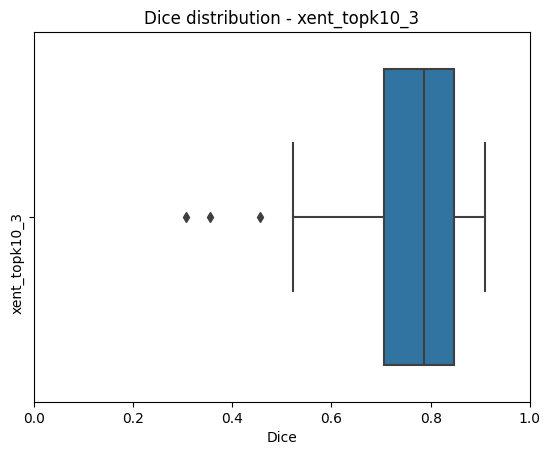

<Figure size 640x480 with 0 Axes>

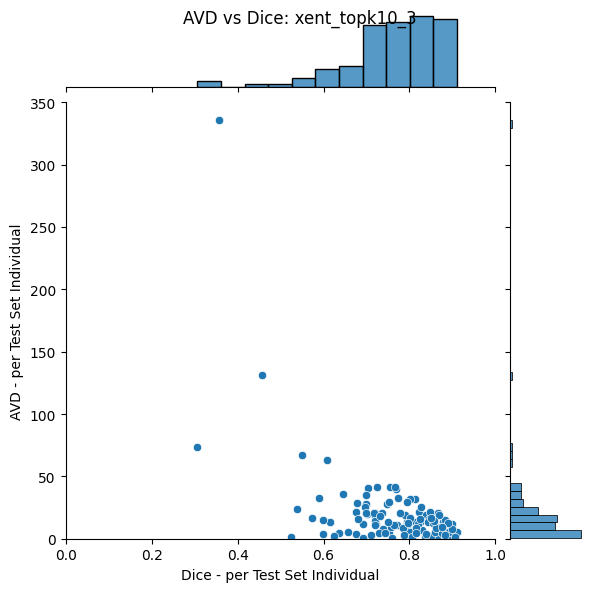

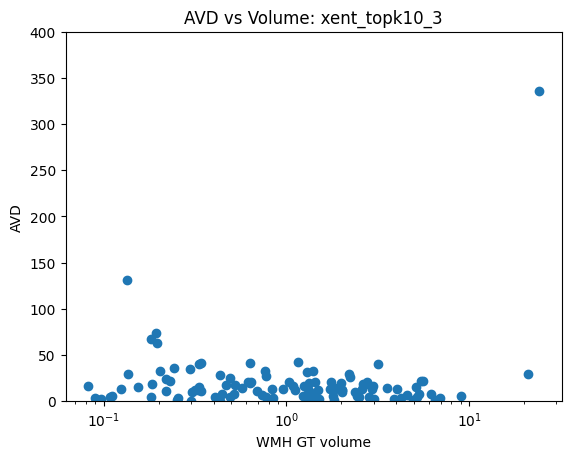

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 122.90it/s]


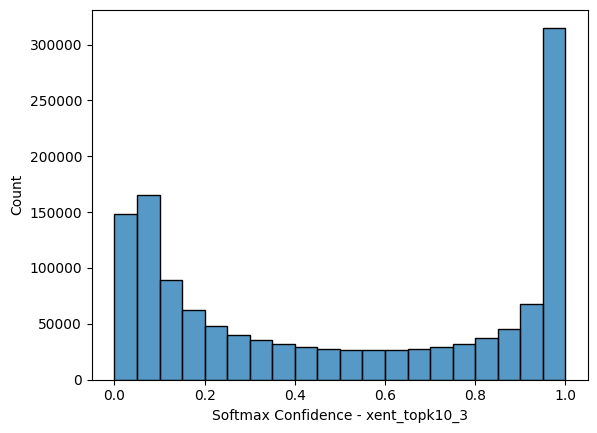

  0%|                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]Mean of empty slice.
invalid value encountered in scalar divide
invalid value encountered in divide
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.35it/s]


ECE:  0.08158587285542584


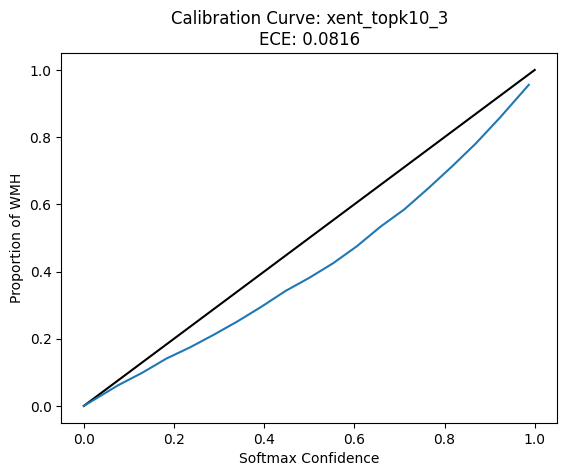

  0%|                                                                                                                                                                 | 0/110 [00:00<?, ?it/s]Mean of empty slice.
invalid value encountered in scalar divide
invalid value encountered in divide
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:08<00:00, 12.66it/s]


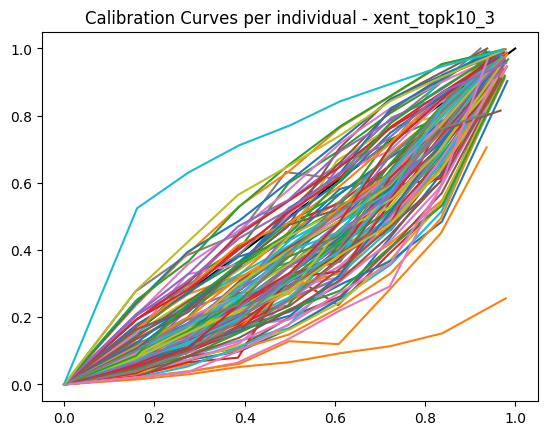

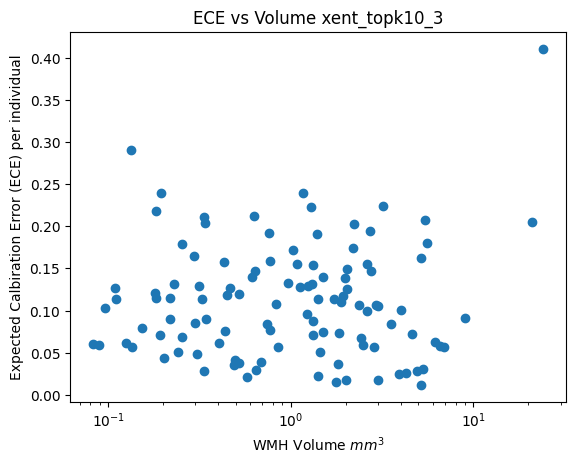

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.21it/s]


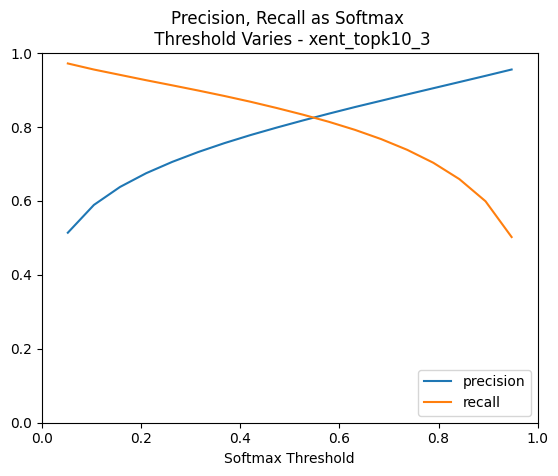

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:25<00:00,  1.14s/it]


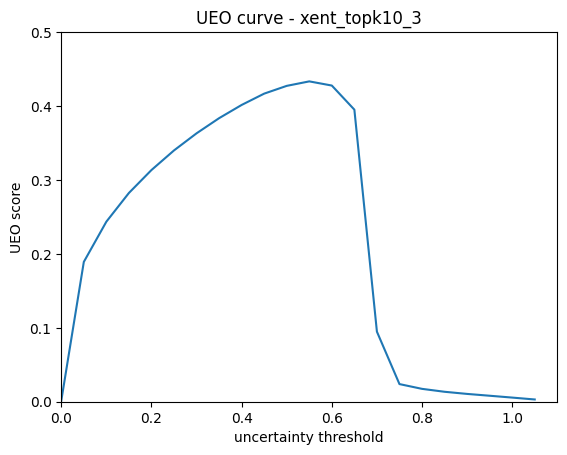

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:15<00:00,  6.91it/s]


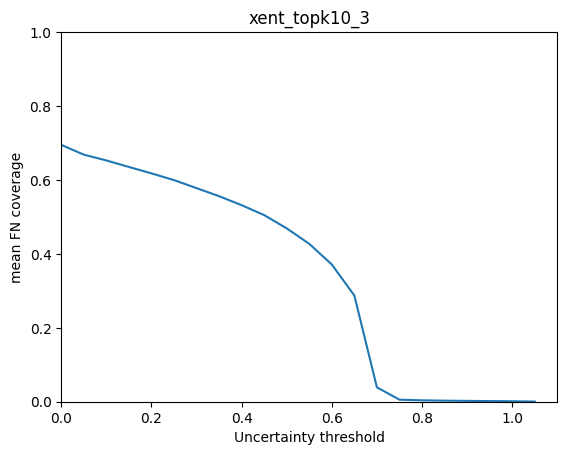

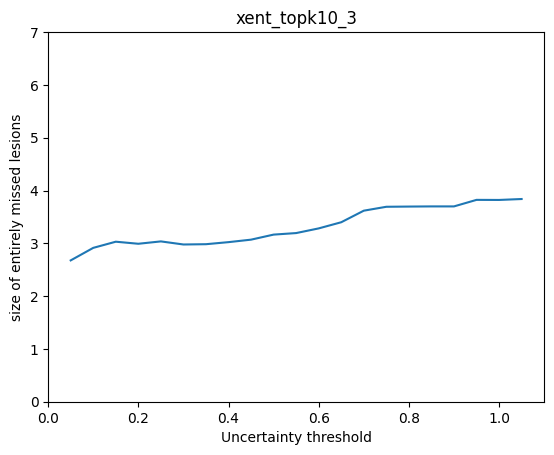

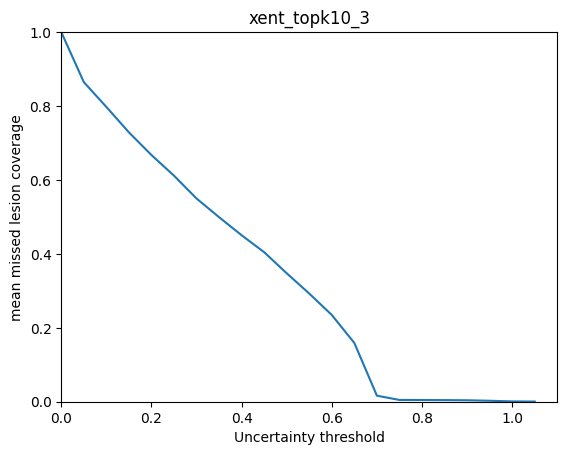

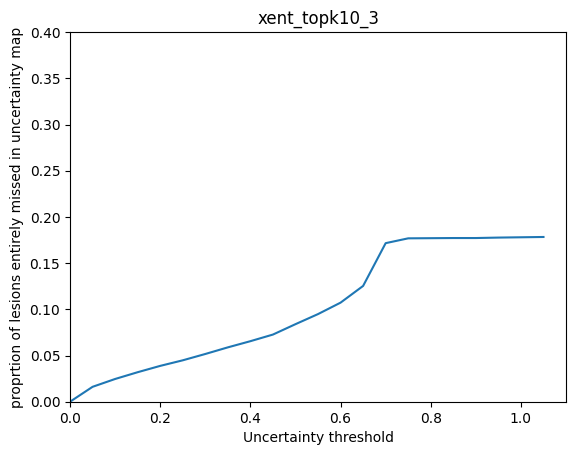

xent_topk1_1
assume folder exists
xent_topk1_2
assume folder exists
xent_topk1_3
assume folder exists
xent_unscaled_1
failed for xent_unscaled_1
xent_unscaled_2
assume folder exists
xent_unscaled_3
assume folder exists
dice_plusplus_gamma2_3
assume folder exists
dice_plusplus_gamma3_1
assume folder exists
dice_plusplus_gamma3_2
assume folder exists
dice_plusplus_gamma3_3
assume folder exists
dice_plusplus_gamma4_1
assume folder exists
dice_plusplus_gamma4_2
assume folder exists
dice_plusplus_gamma4_3
assume folder exists
dice_standard_1
assume folder exists
dice_standard_2
assume folder exists
dice_standard_3
assume folder exists
dice_temp_scaled_1
assume folder exists
dice_temp_scaled_2
assume folder exists
dice_temp_scaled_3
assume folder exists
spherical_alpha2_1
assume folder exists
spherical_alpha2_2
assume folder exists
spherical_alpha2_3
assume folder exists
brier_power2_1
assume folder exists
brier_power2_2
assume folder exists
brier_power2_3
assume folder exists
brier_topk10_1

<Figure size 640x480 with 0 Axes>

In [41]:
for i in range(len(model_dirs)):
    
    folder_name = model_dirs[i]
    print(folder_name)
    
    try:
        ckpt_path = f"{models_root}/{model_dirs[i]}/{natsorted(os.listdir(f'{models_root}/{model_dirs[i]}'))[1]}"
    except:
        print(f"failed for {folder_name}")
        continue
    
    if "partial_temp_scale" in folder_name:
        print("skipping partial temp scale")
        continue
        
    model = StandardLitModelWrapper.load_from_checkpoint(checkpoint_path=ckpt_path, model=model_base, loss=None, optimizer_configurator=custom_optim_config)
    
    try:
        os.mkdir(f"new_model_results/{folder_name}")
    except:
        print("assume folder exists")
        continue
        
    tau = 1
    if "dice_temp_scaled_3" == folder_name:
        tau = 14.5
    elif "dice_temp_scaled_2" == folder_name:
        tau = 19.5
    elif "dice_temp_scaled_1" == folder_name:
        tau = 19.5
    print("tau: ", tau)
        
    preds, preds_dss = load_model_preds(model, tau)
    combined_metrics, metrics_per_domain = combined_challenge_metrics(preds_dss, labels_dss, model, folder_name)
    
    chal_metrics = weighted_challenge_metrics(metrics_per_domain)
    print(chal_metrics)
    
    dice_distribution(combined_metrics, folder_name)
    AVD_Dice_plot(combined_metrics, folder_name)
    AVD_Volume_plot(volumes,combined_metrics , folder_name)
    
    inputs = get_inputs(test_dss)
    labels = get_labels(test_dss)
    c1_preds = [p[1] for p in preds]
    
    try:
        prediction_voxels = get_prediction_voxels(labels, c1_preds, threshold=0.03, steps=0)  
        softmax_confidence_distribution(prediction_voxels, folder_name)    
        (bins, confidences, accuracies), expected_calibration_error = compute_calibration_curve(c1_preds, labels, prediction_threshold=0., num_bins=20)  
        print("ECE: ", expected_calibration_error)
        plot_calibration(confidences, accuracies, expected_calibration_error, folder_name)
        ind_confidences, ind_accuracies, ind_eces = compute_calibration_curve_per_individual(c1_preds, labels, prediction_threshold=0., convert_to_numpy=True, num_bins=10)
        individual_calib_plots(ind_confidences, ind_accuracies, ind_eces, folder_name)
        bins, precisions, recalls = precision_recall_curves(c1_preds, labels)
        precision_recall_curve(bins, precisions, recalls, folder_name)

        ent_maps = softmax_ent(preds)
        u_thresholds = torch.arange(0, 1.1, 0.05)
        ueos = UEO_curve(preds, ent_maps, labels, u_thresholds)
        plot_ueo_curve(u_thresholds, ueos, folder_name)

        bras_score = compute_BraS_Score(u_thresholds, preds, ent_maps, labels, masks)
        mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed = conn_comp_2d_analysis(u_thresholds, labels, preds, ent_maps)

        plot_lesion_coverage_statistics1(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, folder_name)
        plot_lesion_coverage_statistics2(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, folder_name)
        plot_lesion_coverage_statistics3(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, folder_name)
        plot_lesion_coverage_statistics4(u_thresholds, mean_FN_coverage, size_entirely_missed_lesions, mean_missed_lesion_coverage, prop_entirely_missed, folder_name)

        with open(f"new_model_results/{folder_name}/data.txt", "w") as f:
            f.write(f"bras: {bras_score}\n")
            f.write(f"ece: {expected_calibration_error}\n")
            f.write(f"dice: {chal_metrics['dice']}\n")
            f.write(f"f1: {chal_metrics['f1']}\n")
            f.write(f"avd: {chal_metrics['avd']}\n")
            f.write(f"hd95: {chal_metrics['hd95']}\n")
            f.write(f"recall: {chal_metrics['recall']}\n")
            f.write(f"max ueo: {torch.Tensor(ueos).max()}\n")
            f.write(f"undetected clusters at max ueo: {prop_entirely_missed[torch.Tensor(ueos).argmax().item()]}\n")
            f.write(f"confidences: {confidences}\n")
            f.write(f"accuracies: {accuracies}\n")
    except:
        print(f"failed for {folder_name}")
    # break